In [1]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    glucose_levels = []
    basal_insulin = []
    bolus_insulin = []
    carbs = []
    timestamps = []

    # Extract glucose levels
    for glucose_event in root.findall(".//glucose_level/event"):
        ts = glucose_event.get('ts')
        value = float(glucose_event.get('value'))
        glucose_levels.append((ts, value))

    # Extract basal insulin
    for basal_event in root.findall(".//basal/event"):
        ts = basal_event.get('ts')
        value = float(basal_event.get('value'))
        basal_insulin.append((ts, value))

    # Extract bolus insulin
    for bolus_event in root.findall(".//bolus/event"):
        ts = bolus_event.get('ts_begin')
        dose = float(bolus_event.get('dose'))
        bolus_insulin.append((ts, dose))

    # Extract meal data
    for meal_event in root.findall(".//meal/event"):
        ts = meal_event.get('ts')
        carbs_value = float(meal_event.get('carbs'))
        carbs.append((ts, carbs_value))

    # Combine all data into a DataFrame
    data = []
    for ts, glucose in glucose_levels:
        basal = next((value for t, value in basal_insulin if t == ts), 0)
        bolus = next((dose for t, dose in bolus_insulin if t == ts), 0)
        meal = next((carbs_value for t, carbs_value in carbs if t == ts), 0)
        data.append((ts, glucose, basal, bolus, meal))

    df = pd.DataFrame(data, columns=['timestamp', 'glucose', 'basal_insulin', 'bolus_insulin', 'carbs'])
    
    # Specify the correct format for parsing the timestamp
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d-%m-%Y %H:%M:%S')
    
    return df


In [3]:
training_files = [
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/540-ws-training.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/544-ws-training.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/552-ws-training.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/567-ws-training.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/584-ws-training.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/train/596-ws-training.xml'
]

# Paths to testing XML files
testing_files = [
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/540-ws-testing.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/544-ws-testing.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/552-ws-testing.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/567-ws-testing.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/584-ws-testing.xml', 
    'E:/SEM8/Code/Ohio T1DM/OhioT1DM/2020/test/596-ws-testing.xml'
]

# Load and preprocess training data
training_data = [parse_xml(file) for file in training_files]
training_df = pd.concat([data for data in training_data])

# Load and preprocess testing data
testing_data = [parse_xml(file) for file in testing_files]
testing_df = pd.concat([data for data in testing_data])

# Scaling glucose levels and other relevant features
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the features: glucose, basal insulin, bolus insulin, carbs
training_features = training_df[['glucose', 'basal_insulin', 'bolus_insulin', 'carbs']].values
testing_features = testing_df[['glucose', 'basal_insulin', 'bolus_insulin', 'carbs']].values

training_scaled = scaler.fit_transform(training_features)
testing_scaled = scaler.transform(testing_features)


In [4]:
def create_sequences(data, time_steps=10,horizon=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, :-1])  # All features except glucose
        y.append(data[i+time_steps-1, 0])  # Glucose value as the target
    return np.array(X), np.array(y)



In [ ]:
def compute_time_gain(Ts, PH, y_true, y_pred):
    TG = np.zeros(PH)
    for i in range(PH):
        delay = np.abs(y_true[i] - y_pred[i])
        TG[i] = (i + 1) * Ts - delay
    return TG

Training model for 30-minute horizon
Epoch 1/10


d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2048/2048 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - loss: 0.0019 - val_loss: 3.8343e-06
Epoch 2/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 4.5439e-06 - val_loss: 7.1842e-06
Epoch 3/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 3.2783e-06 - val_loss: 1.0209e-06
Epoch 4/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 3.7439e-06 - val_loss: 5.3006e-07
Epoch 5/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 3.5320e-06 - val_loss: 2.0898e-07
Epoch 6/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 3.3264e-06 - val_loss: 4.1057e-07
Epoch 7/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 2.4314e-06 - val_loss: 7.7272e-08
Epoch 8/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 1.3457e-06 - val_loss: 8.3727e-07
Epoch 9/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 1.8455e-06 - val_loss: 3.2765e-07
Epoch 10/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 1.1507e-06 - val_loss: 8.7238e-07
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


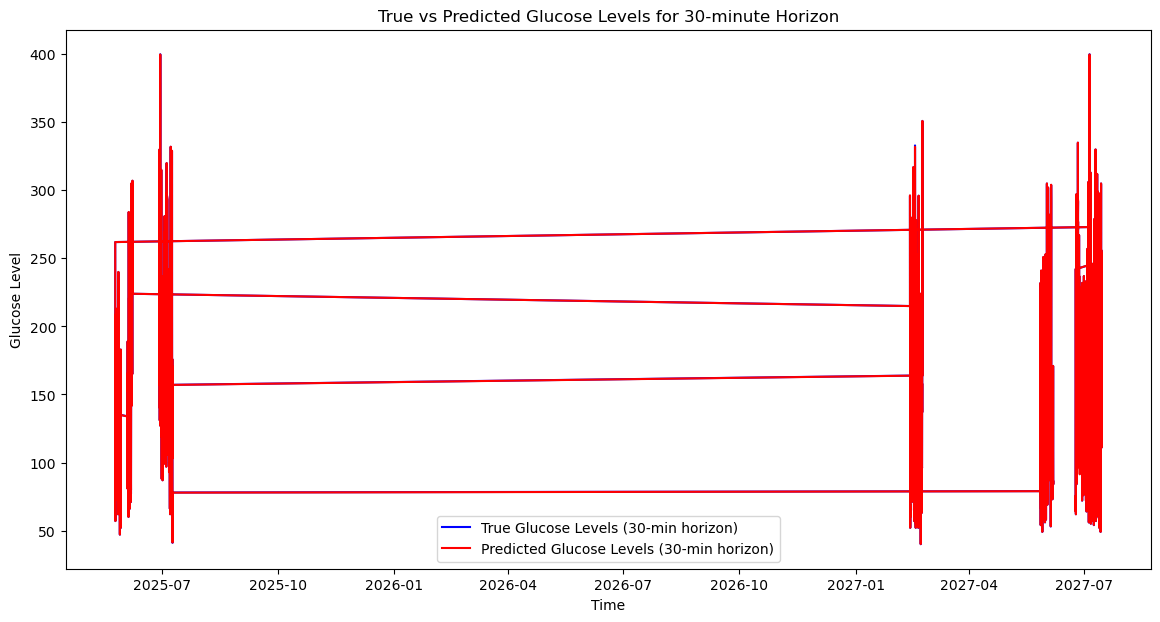

Root Mean Squared Error (RMSE): 0.3362441925678696
Time Gain(TG): [-6.18086433e-05 -9.19075899e-05 -6.29784926e-05 ...  8.05598433e-04
  4.63697645e-04  3.08635623e-04]
Training model for 45-minute horizon
Epoch 1/10


d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2048/2048 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0029 - val_loss: 6.7075e-06
Epoch 2/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 5.3738e-06 - val_loss: 1.5675e-06
Epoch 3/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 2.8737e-06 - val_loss: 3.9503e-07
Epoch 4/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 2.3475e-06 - val_loss: 8.4337e-07
Epoch 5/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 4.8908e-06 - val_loss: 1.6191e-07
Epoch 6/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 2.8595e-06 - val_loss: 2.0142e-07
Epoch 7/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 1.6329e-06 - val_loss: 3.3913e-08
Epoch 8/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 37s 18ms/step - loss: 2.0896e-06 - val_loss: 9.8134e-06
Epoch 9/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - loss: 1.6788e-06 - val_loss: 1.8246e-05
Epoch 10/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 1.6992e-06 - val_loss: 1.4489e-07
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


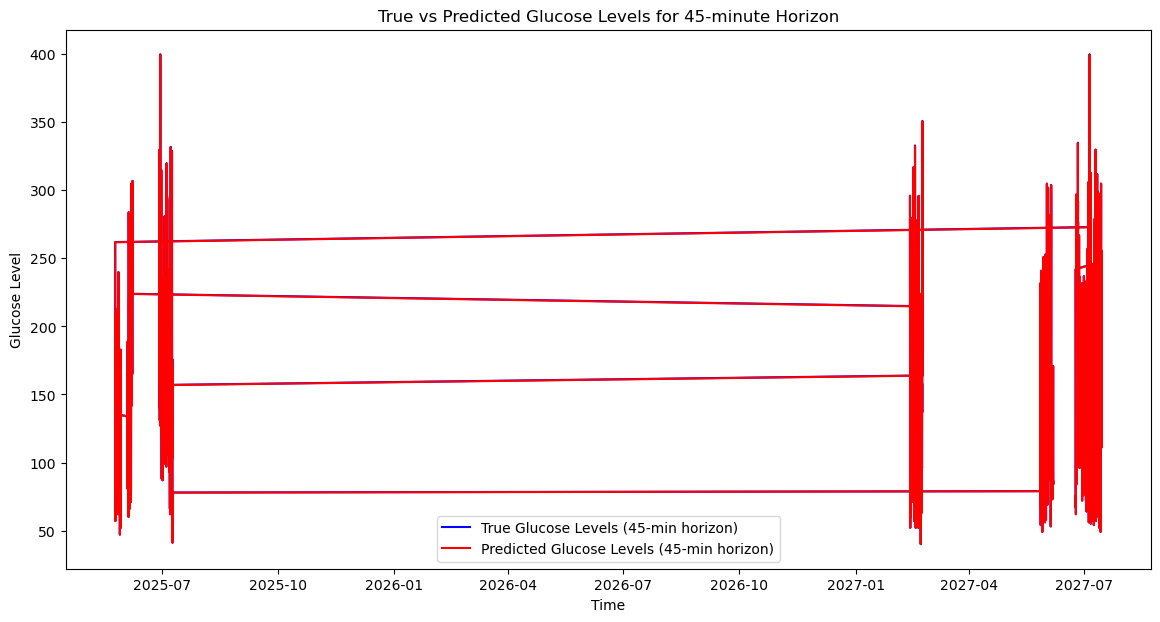

Root Mean Squared Error (RMSE): 0.1370320232199635
Time Gain(TG): [0.00070655 0.00068849 0.0007235  ... 0.0009513  0.00058407 0.00037659]
Training model for 60-minute horizon
Epoch 1/10


d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2048/2048 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0037 - val_loss: 5.0988e-06
Epoch 2/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 5.6255e-06 - val_loss: 2.4695e-06
Epoch 3/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 4.5773e-06 - val_loss: 3.9012e-07
Epoch 4/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 4.4988e-06 - val_loss: 1.8433e-07
Epoch 5/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 3.3194e-06 - val_loss: 1.7120e-07
Epoch 6/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 1.9491e-06 - val_loss: 1.3896e-07
Epoch 7/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 3.0527e-06 - val_loss: 3.4429e-07
Epoch 8/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 1.0809e-06 - val_loss: 4.2749e-08
Epoch 9/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 36s 18ms/step - loss: 2.2169e-06 - val_loss: 2.1281e-08
Epoch 10/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 45s 20ms/step - loss: 4.3963e-06 - val_loss: 1.0584e-07
493/493 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step

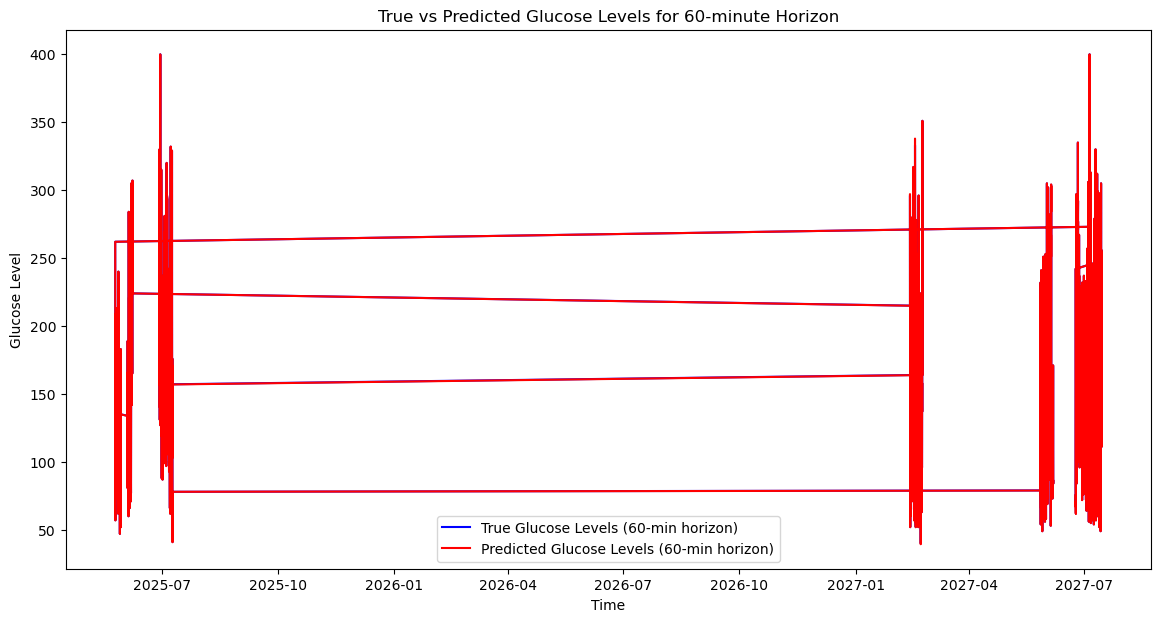

Root Mean Squared Error (RMSE): 0.11712165547416158
Time Gain(TG): [ 2.70720451e-05 -2.16461891e-05  5.32618109e-05 ...  8.88291226e-04
  1.61488851e-03  1.81588461e-03]


In [6]:
horizons = [30, 45, 60]

# GRU Model
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=input_shape))
    model.add(GRU(50, return_sequences=False))
    model.add(Dense(1))  # Output layer for glucose prediction
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train and evaluate model for each horizon
for horizon in horizons:
    print(f"Training model for {horizon}-minute horizon")
    
    # Create sequences for training and testing data
    X_train, y_train = create_sequences(training_scaled, time_steps=10, horizon=horizon)
    X_test, y_test = create_sequences(testing_scaled, time_steps=10, horizon=horizon)
    
    # Build and train the GRU model
    model = build_gru_model((X_train.shape[1], X_train.shape[2]))
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Rescale predictions and actual values back to original scale
    predictions_rescaled = scaler.inverse_transform(np.concatenate([predictions, np.zeros_like(predictions), np.zeros_like(predictions), np.zeros_like(predictions)], axis=-1))[:, 0]
    y_test_rescaled = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros_like(y_test.reshape(-1, 1)), np.zeros_like(y_test.reshape(-1, 1)), np.zeros_like(y_test.reshape(-1, 1))], axis=-1))[:, 0]
    plt.figure(figsize=(14, 7))
    plt.plot(testing_df['timestamp'][len(testing_df) - len(y_test_rescaled):], y_test_rescaled, label=f'True Glucose Levels ({horizon}-min horizon)', color='blue')
    plt.plot(testing_df['timestamp'][len(testing_df) - len(predictions_rescaled):], predictions_rescaled, label=f'Predicted Glucose Levels ({horizon}-min horizon)', color='red')
    plt.xlabel('Time')
    plt.ylabel('Glucose Level')
    plt.title(f'True vs Predicted Glucose Levels for {horizon}-minute Horizon')
    plt.legend()
    plt.show()
    

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    TG = compute_time_gain(5,30,y_test_rescaled, predictions_rescaled)
    print(f"Time Gain(TG): {TG}")
    
    